In [1]:
import ast
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rc('font', family='serif', size=11)

# All Trials

Some of the best models found on the subset...:  
  * $0.176$ cnn	adam	0.01	20	20	[0]	2	[64, 32, 16]	[(4, 2, 0), (3, 1, 0), (3, 2, 0)]  
  * $0.163$ cnn	adam	0.01	10	20	[0]	10	[10, 10, 10]	[(8, 1, 0), (5, 1, 0), (3, 2, 0)]

In [2]:
results = pd.read_csv('../results/results.csv', index_col=[0])
results.error_trace = results.error_trace.map(lambda x: ast.literal_eval(x))
results.head(10)

,model,algo,rho,epochs,batch_size,channels,latent_dim,hidden_dims,ker_str_pad,error_trace,duration
0,cnn,adam,0.01,1,256,[0],3,"[10, 10, 10]","[(8, 1, 0), (5, 1, 0), (3, 2, 0)]","[0.3184973895549774, 0.2860753834247589, 0.261...",352.618608


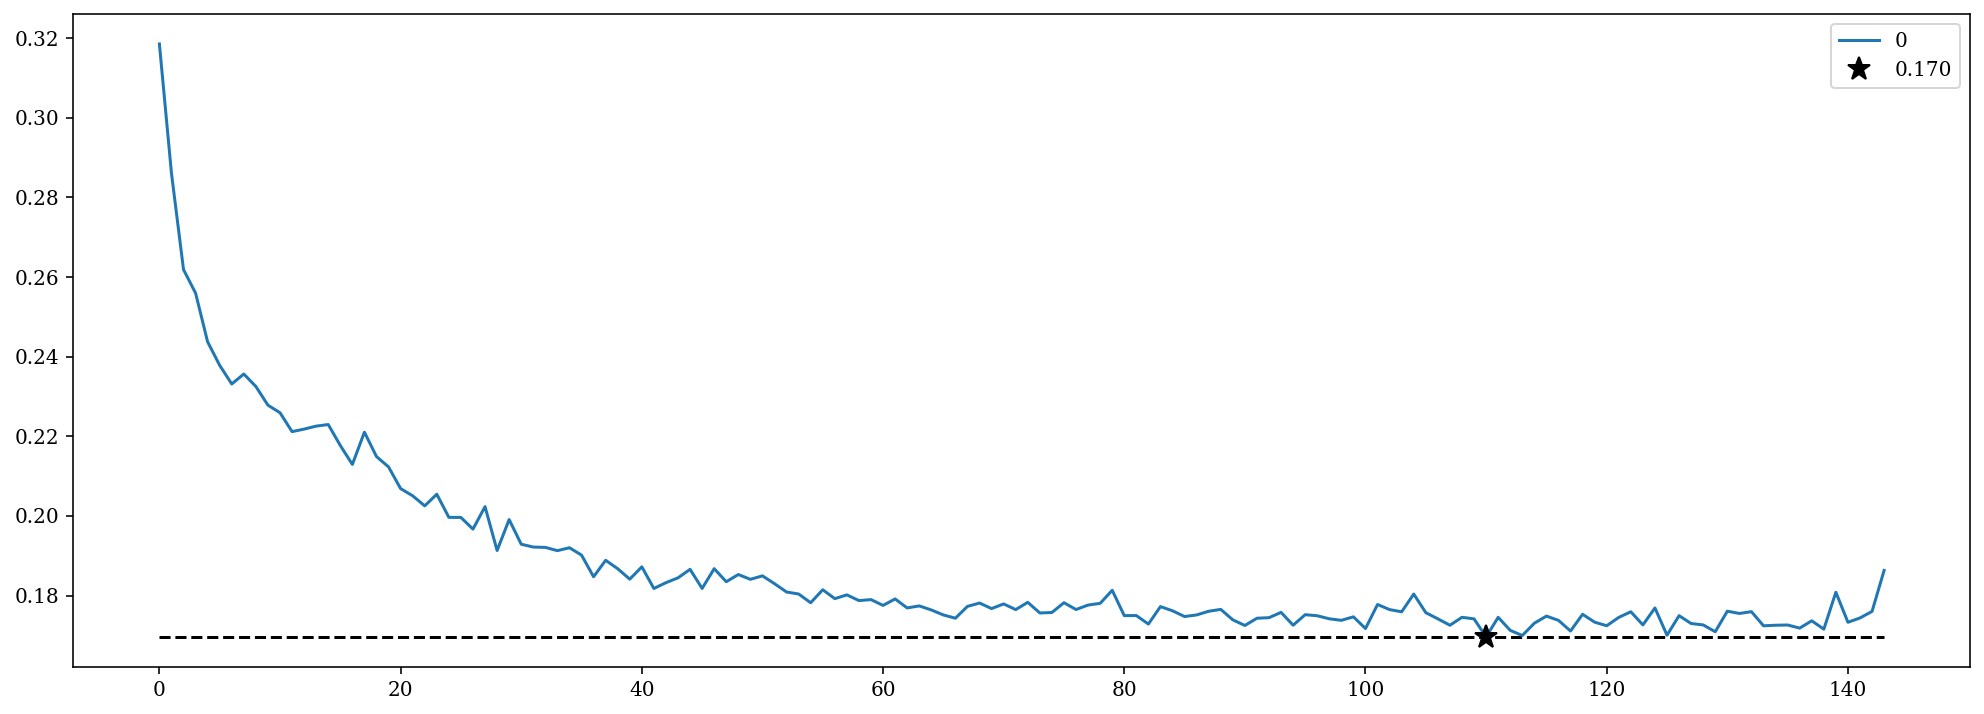

In [3]:
top = 1
max_len = 0
plt.figure(figsize=(17, 6))
for i, row in results.iterrows():
    error = row.error_trace
    plt.plot(error, label=i)
    
    top_index_temp = np.argmin(error)
    top_temp = error[top_index_temp]
    if top_temp < top:
        top = top_temp
        top_index = top_index_temp    
    max_len = max(max_len, len(error))

#! plot the model with the lowest _observed_ error
plt.hlines(top, 0, max_len - 1, linestyle='dashed')
plt.plot(top_index, top, 'k*', markersize=12, label=f'{top:.3f}')

plt.legend();

# Best Model

In [4]:
best = pd.read_csv('../results/best_result.csv', names=['attr','val'])
best.head(len(best))

,attr,val
0,model,cnn
1,algo,adam
2,rho,0.01
3,epochs,1
4,batch_size,256
5,channels,[0]
6,latent_dim,3
7,hidden_dims,"[10, 10, 10]"
8,ker_str_pad,"[(8, 1, 0), (5, 1, 0), (3, 2, 0)]"
9,error_trace,"[0.3184973895549774, 0.2860753834247589, 0.261..."


# Latent Vector of Best Model

In [11]:
latent = pd.read_csv('../results/latent_vectors.csv', index_col=[0])
latent.latent_vector = latent.latent_vector.map(lambda x: ast.literal_eval(x))
#! only look at the first _n_ samples
latent = latent.iloc[:5000]
length = len(latent.latent_vector[0])
print(f'>> {length} dimensional latent space with {len(latent)} samples!')
latent.head()

>> 3 dimensional latent space with 5000 samples!


,filename,label,latent_vector
0,/s/chopin/l/grad/stock/data/eastpac2_20x20/eas...,0,"[0.030755937, -2.0434065, 0.7144729]"
1,/s/chopin/l/grad/stock/data/eastpac2_20x20/eas...,0,"[-0.93780327, -0.5560062, 1.2821515]"
2,/s/chopin/l/grad/stock/data/eastpac2_20x20/eas...,0,"[-1.6672546, -0.93520606, 1.18676]"
3,/s/chopin/l/grad/stock/data/eastpac2_20x20/eas...,2,"[-0.5815415, -0.5786667, 0.12116355]"
4,/s/chopin/l/grad/stock/data/eastpac2_20x20/eas...,2,"[0.77450347, -0.05273828, 0.8789349]"


**NOTES**: plot the latent space in the respective dimension.  
  * 2 dimensions 
  * 3 dimensions at four different angles
  * N dimensions reduced to 2 with PCA and tSNE

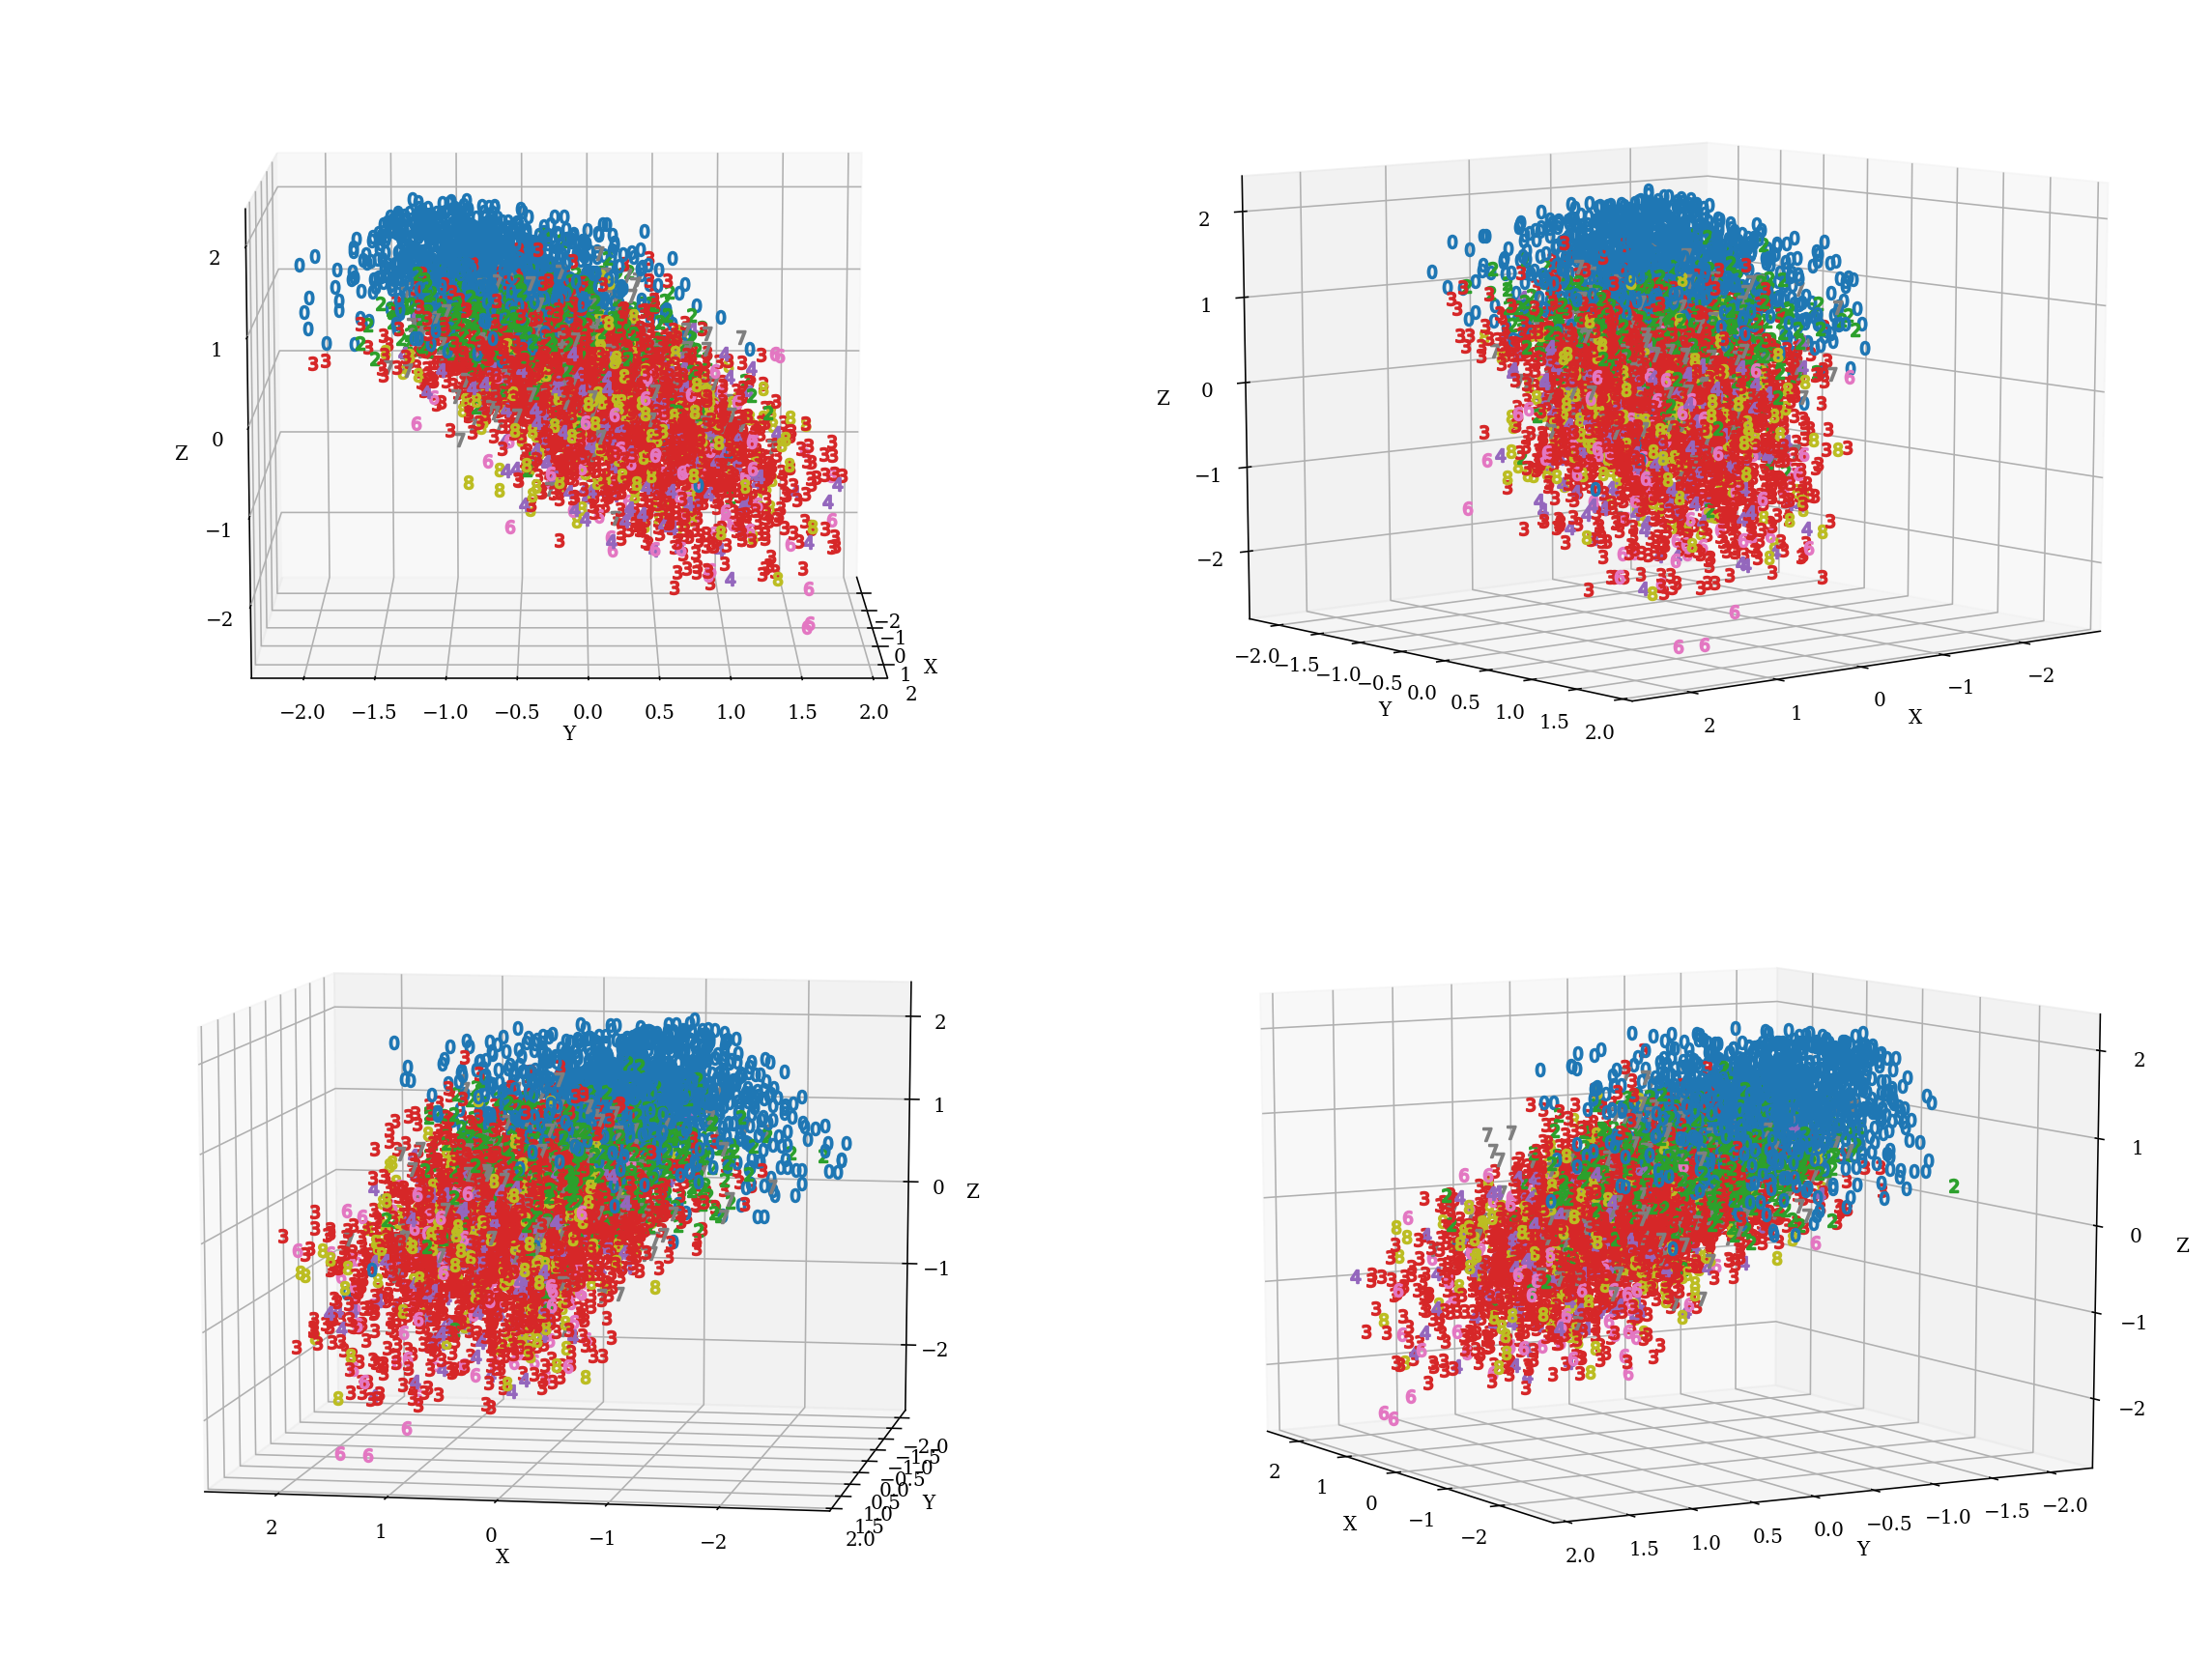

In [12]:
%matplotlib inline

# if more than 10 colors are needed, use Set3.
# COLORS = pl.cm.Set3(np.linspace(0, 1, 12))
COLORS = pl.cm.tab10(np.linspace(0, 1, 10))


#! 2D plot of latent space by labels
if length == 2:
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    
    for i, row in latent.iterrows():
        ax.plot(row.latent_vector[0], row.latent_vector[1], 
                marker='${}$'.format(row.label), c=COLORS[row.label])
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    plt.show()

#! 3D plot of latent space by labels
elif length == 3:
    
    fig = plt.figure(figsize=(16, 12))

    for itr in range(4):
        ax = fig.add_subplot(2, 2, itr+1, projection='3d')

        for i, row in latent.iterrows():
            ax.scatter(row.latent_vector[0], row.latent_vector[1], row.latent_vector[2],
                       marker='${}$'.format(row.label), s=45, c=[COLORS[row.label]])

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

        ax.view_init(elev=10., azim=itr*50)

    plt.tight_layout()
    plt.show()

#! ND plot of latent space by labels using PCA and tSNE dim reduction
else:
    
    X = np.stack(latent.latent_vector, axis=0)
    # the output of the NN is normalized using nn.BatchNorm1d()
    # however, we could also standardize with a mean of 0 and std of 1.
    # X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    
    components = PCA(n_components=2).fit_transform(X)
    embeded = TSNE(n_components=2).fit_transform(X)
    
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(1, 2, 1)

    for i, row in latent.iterrows():
        ax.plot(components[i, 0], components[i, 1], 
                marker='${}$'.format(row.label), c=COLORS[row.label])

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('PCA')

    ax = fig.add_subplot(1, 2, 2)

    for i, row in latent.iterrows():
        ax.plot(embeded[i, 0], embeded[i, 1], 
                marker='${}$'.format(row.label), c=COLORS[row.label])

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('tSNE')

    plt.show()

## Interactive 3D plot 

In [7]:
if length == 3:
    
    %matplotlib notebook

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    for i, row in latent.iterrows():
        ax.scatter(row.latent_vector[0], row.latent_vector[1], row.latent_vector[2],
                   marker='${}$'.format(row.label), s=45, c=[COLORS[row.label]])

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()